In [1]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/burakgozutok/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/burakgozutok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# 1. Read Data

In [3]:
df = pd.read_csv('recipes.csv', delimiter=';')

# Filter nan columns for Ingredients and Directions
df = df[df['Ingredients'].notnull()]
df = df[df['Directions'].notnull()]
df.Directions = df.Directions.apply(lambda x: x.replace('**', ' '))

df.head(2)

,Recipe Name,Review Count,Recipe Photo,Author,Prepare Time,Cook Time,Total Time,Ingredients,Directions,RecipeID
0,Golden Crescent Rolls Recipe,304,https://images.media-allrecipes.com/userphotos...,Mike A.,25 m,15 m,3 h 10 m,"yeast,water,white sugar,salt,egg,butter,flour,...","Dissolve yeast in warm water. Stir in sugar, s...",7000
1,Poppy Seed Bread with Glaze Recipe,137,https://images.media-allrecipes.com/userphotos...,Christina Jun,15 m,1 h,1 h 20 m,"flour,salt,baking powder,poppy,butter,vegetabl...",'Preheat oven to 350 degrees F (175 degrees C)...,7001


#### Create List of Words from Ingredients and recipies

In [4]:
ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if len(item) > 0]))
words_all = [word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]

len(words_all), len(ingredients_all)

100%|██████████| 12345/12345 [00:09<00:00, 1357.05it/s]


(1245567, 942)

# 2. Prepare Data for Model

#### Train Test Split

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(df, test_size=0.1, random_state=42)
X_val, X_test = train_test_split(X_val, test_size=0.5, random_state=42)

len(X_train), len(X_val), len(X_test)

(11110, 617, 618)

#### Split Ingredients and recipes to words seperately for train,test,val

In [6]:
def parse_df(df):
    ingredients_all = list(set([item for row in df.Ingredients for item in row.split(',') if (len(item) > 0 and " " not in item)]))
    words_all = list(set([word for row in tqdm(df.Directions.to_list()) for word in nltk.word_tokenize(row)]))
    
    #Put label 0 to normal words and 1 to ingredients.
    words_0 = list(set(words_all) - set(ingredients_all))
    words_1 = ingredients_all
    
    # Combine 0s and 1s
    x = words_0 + words_1
    y = [0 for i in range(len(words_0))] + [1 for i in range(len(words_0))]
    
    # Shuffle data
    c = list(zip(x, y))
    random.shuffle(c)
    x, y = zip(*c)
    
    assert len(x) == len(y)
    return x,y

X_train_words, y_train_words = parse_df(X_train)
X_val_words, y_val_words = parse_df(X_val)
X_test_words, y_test_words = parse_df(X_test)

100%|██████████| 618/618 [00:00<00:00, 1466.57it/s]


# Vectorize Text

In [7]:
# Load FastText Model
#
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft_model = fasttext.load_model('cc.en.300.bin')

In [8]:
# Vectorize Words
# 
X_train_vectors = [ft_model.get_sentence_vector(x) for x in X_train_words]
X_val_vectors = [ft_model.get_sentence_vector(x) for x in X_val_words]
X_test_vectors = [ft_model.get_sentence_vector(x) for x in X_test_words]

X_train_vectors = np.expand_dims(np.array(X_train_vectors), axis=2)
X_val_vectors = np.expand_dims(np.array(X_val_vectors), axis=2)
X_test_vectors = np.expand_dims(np.array(X_test_vectors), axis=2)

y_train_words = np.array(y_train_words)
y_val_words = np.array(y_val_words)
y_test_words = np.array(y_test_words)

X_train_vectors.shape, X_val_vectors.shape, X_test_vectors.shape

((7465, 300, 1), (2548, 300, 1), (2579, 300, 1))

# 1D CNN Model

In [9]:
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D

from tensorflow.keras.callbacks import EarlyStopping

/Users/burakgozutok/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/burakgozutok/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/burakgozutok/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/burakgozutok/opt/anaconda3/lib/python3.8/s

### Create Model and show summary

In [10]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=8, activation='relu',input_shape=(300,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 293, 16)           144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 146, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2336)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2336)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                37392     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 37,553
Trainable params: 37,553
Non-trainable params: 0
_________________________________________________________________


### Calculate Class Weights for the imbalance

In [11]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train_words), class_weight.compute_class_weight('balanced', np.unique(y_train_words), 
                y_train_words))) 
class_weights

/Users/burakgozutok/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 0.5250386833591223, 1: 10.484550561797754}

### Train Model

In [12]:
early_stop = EarlyStopping(monitor='loss', patience=5)

history = model.fit(
        X_train_vectors, y_train_words, 
        validation_data=(X_val_vectors,y_val_words), 
        batch_size=32, 
        epochs=100,
        class_weight=class_weights,
        callbacks=[early_stop]
        )

Train on 7465 samples, validate on 2548 samples
Epoch 1/100
7465/7465 [==============================] - 1s 157us/step - loss: 0.6609 - acc: 0.9344 - val_loss: 0.5378 - val_acc: 0.9078
Epoch 2/100
7465/7465 [==============================] - 1s 137us/step - loss: 0.5927 - acc: 0.9512 - val_loss: 0.4629 - val_acc: 0.9195
Epoch 3/100
7465/7465 [==============================] - 1s 154us/step - loss: 0.5241 - acc: 0.9257 - val_loss: 0.4242 - val_acc: 0.8964
Epoch 4/100
7465/7465 [==============================] - 1s 125us/step - loss: 0.4744 - acc: 0.8930 - val_loss: 0.3636 - val_acc: 0.8976
Epoch 5/100
7465/7465 [==============================] - 1s 114us/step - loss: 0.4337 - acc: 0.8977 - val_loss: 0.3970 - val_acc: 0.8611
Epoch 6/100
7465/7465 [==============================] - 1s 115us/step - loss: 0.4072 - acc: 0.8880 - val_loss: 0.3494 - val_acc: 0.8756
Epoch 7/100
7465/7465 [==============================] - 1s 130us/step - loss: 0.3914 - acc: 0.8895 - val_loss: 0.3344 - val_acc: 

7465/7465 [==============================] - 1s 104us/step - loss: 0.2341 - acc: 0.9137 - val_loss: 0.2302 - val_acc: 0.9046
Epoch 61/100
7465/7465 [==============================] - 1s 109us/step - loss: 0.2375 - acc: 0.9156 - val_loss: 0.2168 - val_acc: 0.9066
Epoch 62/100
7465/7465 [==============================] - 1s 100us/step - loss: 0.2288 - acc: 0.9164 - val_loss: 0.2334 - val_acc: 0.9031
Epoch 63/100
7465/7465 [==============================] - 1s 96us/step - loss: 0.2275 - acc: 0.9148 - val_loss: 0.2594 - val_acc: 0.8932


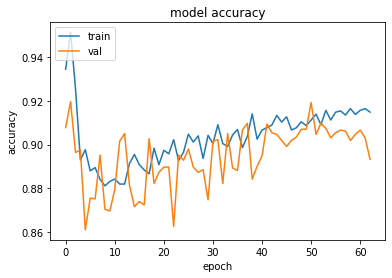

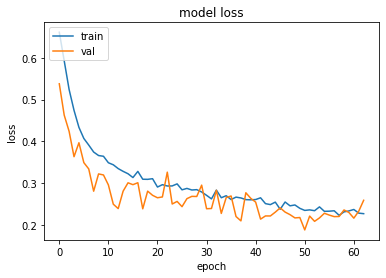

In [13]:
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluate

In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_vectors).squeeze()
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

print(classification_report(y_test_words,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2355
           1       0.45      0.98      0.62       224

    accuracy                           0.89      2579
   macro avg       0.72      0.93      0.78      2579
weighted avg       0.95      0.89      0.91      2579



# Inference

In [15]:
def recipe_to_target_words(recipe):
    """
        Create word list from recipe. Include 2-gram and 3-grams.
    """
    words = nltk.word_tokenize(recipe)
    #Create vector for each word
    word_vectors = np.array([ft_model.get_word_vector(word) for word in words])

    targets = []
    for i in range(len(word_vectors)):    
        
        # Calculate mean vector for n-grams.
        n_gram_1 = word_vectors[i:i+1].mean(axis=0)
        n_gram_2 = word_vectors[i:i+2].mean(axis=0)    
        n_gram_3 = word_vectors[i:i+3].mean(axis=0)
    
        targets.append((words[i], n_gram_1))
        targets.append((' '.join(words[i:i+2]), n_gram_2))
        targets.append((' '.join(words[i:i+3]), n_gram_3))
    
    return targets

word,vec = recipe_to_target_words(X_test.iloc[0].Directions)[61]
word, vec.shape

('nutmeg .', (300,))

In [16]:
def predict(text):
    """
        Prediction function
    """
    # Get target word list
    targets = recipe_to_target_words(text)
    
    # Seperate words and vectors
    words = [t[0] for t in targets]
    vecs = np.array([np.expand_dims(t[1],axis=1) for t in targets])
    
    # Create prediciton for each word or n-gram
    y_pred = model.predict(vecs) 
    y_pred = np.squeeze(y_pred > 0.5).astype(int)
    
    result = []
    for w,p in zip(words,y_pred):
        # if prediction is 1 --> Ingredient. add to list
        if p==1:
            result.append(w)
            
    return result
    
predict(X_test.iloc[0].Directions)

['apricot',
 'apricot preserves',
 'fruit',
 'fruit cocktail',
 'fruit cocktail and',
 'cocktail',
 'Dijon mustard',
 'mustard',
 'add nutmeg',
 'nutmeg']

In [17]:
from nltk.corpus import wordnet

In [18]:
def post_filter(items):    
    """
        Post filtering function of n-gram results. to have clear text
    """
    
    # Seperate multiple words by comma & "and" word
    filtered = []
    for f in items:
        if ',' in f:
            filtered += f.split(',')
        if 'and' in f:
            filtered += f.split('and')
        if 'and' not in f and ',' not in f:
            filtered.append(f)
                        
    filtered = list(set(filtered))        
    filtered = [f.strip() for f in filtered if len(f) > 0]
    
    # SINGULARIZE plural words
    filtered = [f if wordnet.morphy(f) is None else wordnet.morphy(f) for f in filtered]    
    
    # filter duplicate words by n-grams
    filtered = sorted(filtered, key=lambda x: len(x.split()), reverse=True)    

    
    # remove single word of "cup"
    ignore_items = ["cup"]
    filtered = list(set(filtered) - set(ignore_items))   
    
    return filtered

print(post_filter(predict(X_test.iloc[7].Directions)))
print(X_test.iloc[7].Ingredients)

['frost with lemon', 'lemon frosting', 'cake mix', 'Let cake', 'water', 'flour', 'pudding', 'bundt', 'Let cake cool', 'cake', 'with lemon frosting', 'sugar', 'Combine cake mix', 'lemon', 'eggs', 'frosting', 'oil', 'Combine cake', 'pudding mix', 'flour one', 'with lemon', 'cake cool']
lemon,lemon,egg,water,vegetable oil


In [19]:
post_filter(predict('In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.'))

['soda',
 'brown',
 'cinnamon',
 'baking powder',
 'milk',
 'raisin',
 'Add apple',
 'flour',
 'salt',
 'combine flour',
 'brown sugar',
 'apple',
 'powder',
 'sugar',
 'eggs',
 'oil',
 'nut',
 'baking',
 'nutmeg',
 'oat',
 'baking soda']

# Calculate Positions from Text

In [20]:
def create_result(text):
    ingredients = post_filter(predict(text))
    
    matches = []
    for item in ingredients:
        matches += [[item, match.start(),match.end()] for match in re.finditer(item, text)]
    
    return matches

In [21]:
create_result('In a large bowl, combine flour, baking powder, baking soda, salt, cinnamon, nutmeg, brown sugar, and  oats. Add apple, nuts, raisins, eggs, milk, and oil.  Mix until dry ingredients are moistened.**Bake for 55 to 60 minutes, or until done.  Cool on wire rack.')



[['soda', 54, 58],
 ['brown', 84, 89],
 ['cinnamon', 66, 74],
 ['baking powder', 32, 45],
 ['milk', 140, 144],
 ['raisin', 125, 131],
 ['Add apple', 108, 117],
 ['flour', 25, 30],
 ['salt', 60, 64],
 ['combine flour', 17, 30],
 ['brown sugar', 84, 95],
 ['apple', 112, 117],
 ['powder', 39, 45],
 ['sugar', 90, 95],
 ['eggs', 134, 138],
 ['oil', 150, 153],
 ['nut', 76, 79],
 ['nut', 119, 122],
 ['nut', 218, 221],
 ['baking', 32, 38],
 ['baking', 47, 53],
 ['nutmeg', 76, 82],
 ['oat', 102, 105],
 ['baking soda', 47, 58]]

In [23]:
import tensorflow
tensorflow.keras.models.save_model(model,"model_1dcnn.h5")